# 1. Introduction

__The problem__

Forecasting viral disease spread is a critical public health concern and complex data science problem. The interaction of virus-specific factors such as nature of transmission and replication coupled with policies implemented by government and health officials make the spread of different viral diseases variable and difficult to predict. The current coronavirus-19 (COVID-19) pandemic represents an instance where forecasting spread is especially complex, given the novelty of the virus itself, its context in a highly globalized world, and widespread implementation of social separation guidelines. With ongoing spread and risk of dangerous [future outbreaks](https://www.newsweek.com/cdc-director-coronavirus-wave-late-fall-substantial-portion-americans-will-susceptible-1495401), forecasting COVID-19 spread deserves massive attention.

The abundance of COVID-19 case counts over time in publically-available datasets (Such as the [Johns Hopkins
](https://coronavirus.jhu.edu/us-map) dashboard or [New York Times](https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html) dataset) may make it possible to predict COVID-19 outbreaks using data types such as internet [search queries](https://trends.google.com/trends/?geo=US) or [mobility data](https://www.google.com/covid19/mobility/) collected by Google. This type of data has been used to forecast [influenza](https://www.nature.com/articles/nature07634) and [dengue](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1005607). A major advantage of this approach is that it involves large sample sizes such that high granularity in forecasting outbreaks may be achieved.


__Our model__

We hypothesize that the COVID-19 spread in the United States at the county level can be modeled using a Long Short-Term Memory (LSTM) model trained using time-series data on mobility to various categories of locations (e.g., grocery stores, parks, etc.) as documented by Google Mobility. An LSTM is a type of neural network that is especially well-suited for modeling time series data (as in case counts of COVID-19 in certain regions measured periodically) since it is composed of layered units containing input, output, and forget gates that regulate information transfer through the model. An improvement on other recurrent neural network types, LSTMs are not as susceptible to the so-called vanishing gradient problem that can stall the process of updating weights in local optima. 

__Approach__

Our specific approach is to use mobility data and previous COVID-19 case counts to predict future COVID-19 counts at the county level. In addition to achieving high predictive power, our model is advantageous because it is amenable to adding in other predictors such as economic factors or Google Trends search terms with the same architecture. We train our many-to-one LSTM model dynamically, updating the model each day when additional data is used. To incorporate different availability of data at the county level, we train with stochastic gradient descent (as opposed to mini batch training). We use data from February 15 to April 26 to undertake the training and aim to model as our outcome variable the log of the number of cases per 100,000 people. 



____
____

# 2. Import and Clean Data

#### Import packages

In [103]:
# Import packages
import os
import numpy as np
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler as SS
from statsmodels.tsa.tsatools import lagmat
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator as TSG
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, TimeDistributed, BatchNormalization, Activation
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.layers import Flatten
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, TensorBoard
from tensorflow.keras import optimizers 
import tensorflow as tf
%matplotlib inline

# Define functions to be used later
def mse(y, yhat):
    return np.mean( (y - yhat)**2 ) 


####  Import mobility, cases, and population

We use the three following data sources:

1. Mobility (*mob*): this contains mobility data from Google. For any given date in any given county, the mobility data indicates how much that county's mobility has changed relative to its baseline in 6 different categories: retail, groceries, parks, transit, work, and residential. Since we hypothesize taht decreasing mobility will correspond to lower transmission (except in the residential category, where the opposite is true), we use this data as a predictor of cases. 

2. Case counts (*nyt*): this data from the New York Times tells us the number of cases per county on any individual day. The number of cases is both our outcome variable and a predictor since we are running a time-series model. 

3. Population (*pop*): this data gives us U.S. Census Bureau's estimate of the population of each county (2019). We find it is easier to model cases per capita than cases overall since this compresses the target variable to be within a smaller range. 

In [104]:
# ## Generate mobility dataframe from original global mobility file
# # Note: only run this if us_mobility.csv isn't already created

# global_mob = pd.read_csv('../Global_Mobility_Report.csv', dtype = {'sub_region_2':object}) # read in global mobility
# mob = global_mob[global_mob['country_region'] == 'United States'].drop(columns = ['country_region_code','country_region']) # only keep U.S.
# mapper1 = {'sub_region_1':'state', 'sub_region_2':'county'} # rename stuff
# mapper2 = pd.Series(index = mob.columns[3:], data = ['retail','grocery','parks','transit','work','residential']) # rename other stuff
# mob.rename(columns = mapper1, inplace = True) # rename
# mob.rename(columns = mapper2, inplace = True) # rename
# mob.loc[mob['state'] == 'District of Columbia', 'county'] = 'DC' # rename DC to match NYT
# mob = mob[(~pd.isnull(mob['state'])) & (~pd.isnull(mob['county']))].reset_index(drop = True) # drop null counties
# mob['county'] = mob.county.str.replace(' County', '') # replace the word "County"
# mob['date'] = mob['date'].apply(lambda date: dt.strptime(date, '%Y-%m-%d')) # make date into datetime object
# mob.to_csv('data/us_mobility.csv', index = False) # Save

In [105]:
## Read in Mobility Dataframe

mob = pd.read_csv("C:/Users/adity/Downloads/COVID19_forecasts-master/COVID19_forecasts-master/data/us_mobility.csv") # Read in df
mob['county'] = mob['county'].str.replace(' Parish', '') # Replace parish with nothing (county already replaced with nothing)
mob['date'] = mob['date'].apply(lambda date: dt.strptime(date, '%Y-%m-%d')) # make date into datetime object
mob.head() # preview


,state,county,date,retail,grocery,parks,transit,work,residential
0,Alabama,Autauga,2020-02-15,5.0,7.0,NaN,NaN,-4.0,NaN
1,Alabama,Autauga,2020-02-16,0.0,1.0,-23.0,NaN,-4.0,NaN
2,Alabama,Autauga,2020-02-17,8.0,0.0,NaN,NaN,-27.0,5.0
3,Alabama,Autauga,2020-02-18,-2.0,0.0,NaN,NaN,2.0,0.0
4,Alabama,Autauga,2020-02-19,-2.0,0.0,NaN,NaN,2.0,0.0


In [106]:
## Read in Counts

nyt = pd.read_csv(f'C:/Users/adity/Downloads/COVID19_forecasts-master/COVID19_forecasts-master/data/us-counties.csv').drop(columns = 'fips') # read in NYT data on counts
nyt['date'] = nyt['date'].apply(lambda date: dt.strptime(date, '%Y-%m-%d')) # make date into datetime
nyt['county'] = nyt.county.str.replace('City', '').str.strip() # strip "City" from county with the name "city" (E.g. NYC)
nyt.head() # preview


,date,county,state,cases,deaths
0,2020-01-21,Snohomish,Washington,1,0
1,2020-01-22,Snohomish,Washington,1,0
2,2020-01-23,Snohomish,Washington,1,0
3,2020-01-24,Cook,Illinois,1,0
4,2020-01-24,Snohomish,Washington,1,0


In [107]:
## Merge mobility and counts 

mob = mob.merge(nyt, how = 'left', on = ['state','county','date']) # Merge mobility data with NYT case counts
mob['cases'].fillna(0, inplace = True) # if cases are nan, that means they hadn't had cases
mob['deaths'].fillna(0, inplace = True) # if cases are nan, that means they hadn't had deaths


In [108]:
## Add in populations (when possible)

pop = pd.read_csv('C:/Users/adity/Downloads/COVID19_forecasts-master/COVID19_forecasts-master/data/pop.csv') # read population
mob = pd.merge(mob, pop, on = ['state','county'], how = 'left') # merge


#### Miscellaneous cleaning 

This section accomplishes a few miscellaneous tasks. The most important of these given below 

- We track cases per 100,000 residents rather than cases alone in order to limit the range of the target variable. We also look at the log of this variable since the data is heavily positively skewed.
- We also consider forecasting daily new cases rather than cases total. However, to our surprise, we find our model does a better job of predicting overall cases than daily new cases.
- Finally we decide which categories to use from the mobility data and which counties to consider. We cut some categories and counties because there are high rates of missing values for certain counties and categories. We find that the majority of values are missing for the residential, transit, and park categories, so we decide not to use those, leaving us with grocery, retail, and workplace mobility. We then consider which counties to keep. To do this, we see in each county what percent of dates have non-missing values for the three categories. We make a histogram of these percentages (TODO) and see a natural cutoff of 35%—this means that a county can have missing values for one of the three categories on up to 35% of its dates before we drop it from consideration.

In [109]:
# County ID
mob['ID'] = mob.groupby(['state','county']).ngroup() # assign each county an ID
# Days
first_day = mob.date.min() # first day in dataset
mob['days_in'] = (mob['date'] - first_day).apply(lambda date: date.days) # count days in from start
# Per Capita
mob['casespc'] = 100000*mob['cases']/mob['pop'] # cases per 100k
mob['logcasespc'] = np.log(1 + mob['casespc']) # log(1 + casespc)
# Lags
mob['diffcounty'] = (mob['county'] != mob['county'].shift(1)) # binary for whether its a different county than the one before
mob['new'] = mob['cases'] - mob['cases'].shift(1) # get difference in cases 
mob.loc[mob['diffcounty'] == True, 'new'] = np.nan # if it's the first observation for that county, set "lag" to none
mob.loc[mob['new'] < 0, 'new'] = 0 # sometimes negative if NYT changes case counts 
mob.loc[mob['date'] == mob['date'].min(), 'new'] = 0 # set equal to 0 for first day
mob['newpc'] = 100000*mob['new']/mob['pop'] # new per 100k
mob['lognewpc'] = np.log(1 + mob['newpc']) # log of that 

In [110]:
## Decide whether to keep counties and columns based on response rates (how often they're missing mobility data)

# pick columns
cats = ['grocery','retail','work'] # Categories to predict with 
fullcats = ['grocery','parks','residential','retail','transit','work'] # other categories
mob.drop(columns = [col for col in fullcats if col not in cats], inplace = True) # drop other categories 

# pick rows/counties
missingrates = mob.groupby(['state','county','ID'])[cats].agg(lambda x: np.mean(pd.isnull(x))).reset_index() # missing rates by column for cats
allowance = 0.35 # what percent you're allowed to have missing without getting cut (check distplots of missingrates for reasonable cutoff)
keeper_IDs = missingrates.loc[(missingrates[cats] < allowance).sum(1) == 3, 'ID'].values # IDs of counties with all 3 under allowance
mob = mob[mob['ID'].isin(keeper_IDs)] # only keep those ones
mob.fillna(mob.groupby(['ID','state','county'])[cats].transform('median'), inplace = True) # fill in with median for group
mob = mob.loc[mob.groupby('ID')['casespc'].transform(lambda x: np.mean(pd.isnull(x))) == 0] # remove counties with missing cases pc ## CULPRIT 
mob.reset_index(inplace = True, drop = True) # reset index


____
____

# 3. EDA



The below EDA shows three plots we used to inform our model. The first is the overall case count in the United States. This gives us a sense of how our outcome variable is changing over time. The second shows a KDE of cases and of log cases per 100,000 residents. The extreme right skew in the first shows us that the presence of outliers might be harmful to our model. Instead we opt for the second which, while still skewed, is less extremely so. Finally, we plot the average of the three mobility measures in our model by month. We see, as we expected, that all three are decreasing. This suggests to us that mobility might tell us something about case counts, though we let the model decide how much so. 

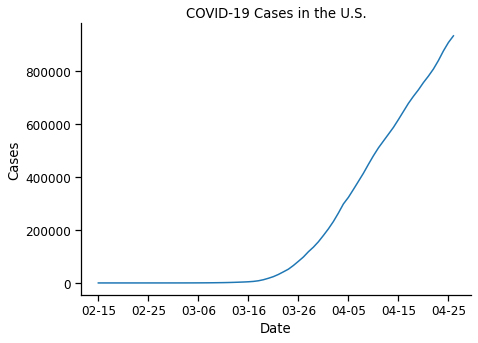

In [111]:
sns.set_context('notebook', font_scale = 1.1)
fig, ax = plt.subplots(figsize = (7, 5))
country = mob.groupby('date').sum().reset_index()
dates = country.date.astype(str).str.replace('2020-','')
sns.lineplot(dates, country.cases, ci = None)
ax.set(xticks = dates[::10], xticklabels = dates[::10])
ax.set(xlabel = 'Date', ylabel = 'Cases', title = 'COVID-19 Cases in the U.S.');
sns.despine();

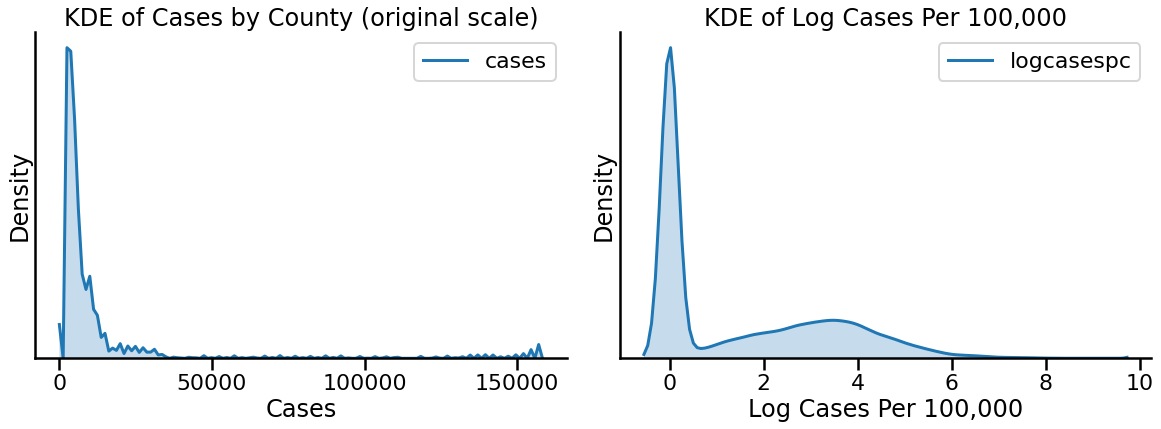

In [112]:
## Note the skew 

sns.set_context('poster')
fig, ax = plt.subplots(1, 2, figsize = (20,6))
sns.kdeplot(mob['cases'], shade = True, ax = ax[0])
ax[0].set(xlabel = 'Cases', ylabel = 'Density', title = 'KDE of Cases by County (original scale)')
ax[0].set(yticks = [], yticklabels = []);
ax[0].set(xticks = ax[0].get_xticks()[1::2], xticklabels = ax[0].get_xticks()[1::2].astype(int))


sns.kdeplot(mob['logcasespc'], shade = True, ax = ax[1])
ax[1].set(xlabel = 'Log Cases Per 100,000', ylabel = 'Density', title = 'KDE of Log Cases Per 100,000')
ax[1].set(yticks = [], yticklabels = []);
sns.despine()
plt.subplots_adjust(wspace = 0.1)

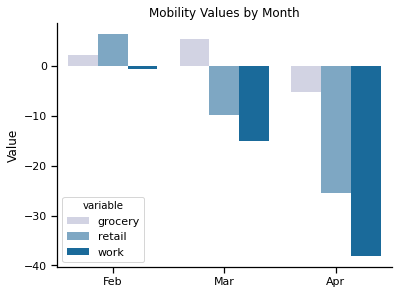

In [113]:
sns.set_context('notebook')
mob['month'] = mob['date'].astype(str).apply(lambda x: x[5:7])
mob['month'] = mob['month'].replace('02', 'Feb').replace('03','Mar').replace('04','Apr')
grouped = mob.groupby('month').mean().reset_index()[['month'] + cats].melt(['month'])
grouped.sort_values('month')
fig, ax = plt.subplots(figsize = (6,4.5))
sns.barplot(data = grouped, x = 'month', y = 'value', hue = 'variable', order = ['Feb','Mar','Apr'], palette = 'PuBu');
ax.set(xlabel = '', ylabel = 'Value', title = 'Mobility Values by Month');
sns.despine()

____
____

# 4. Modeling

#### Create Generator class

This class is used to feed the data into the Keras model. Since different counties have different numbers of timesteps (i.e. different number of dates available for training), we cannot fit the entire training set into one tensor (without adding padding, which is not ideal for modeling a continuous quantitative outcome). Instead, the generator returns batches of size 1, so that each county is its own batch. In each epoch, the generator returns county-batches one at a time and between epochs it shuffles the order of counties.  

In [114]:
# credits to https://datascience.stackexchange.com/questions/13894/how-to-get-predictions-with-predict-generator-on-streaming-test-data-in-keras
class Generator(Sequence):
    'Generates data in batches for Keras'
    
    def __init__(self, X, y, batch_size = 1, shuffle = True):
        'Initialization'
        self.X = X
        self.y = y
        self.batch_size = batch_size # batch size should be 1 since we have samples with different numbers of timesteps
        self.shuffle = shuffle # whether to shuffle on epoch end or not 
        self.on_epoch_end() # call on epoch end 
    
    def __len__(self):
        'Gives number of batches per epoch, |_len(y)/batch_size_|'
        return int(np.floor(len(self.y)/self.batch_size)) # Get number of batches 
    
    def __getitem__(self, index):
        'returns a single batch'
        return self.__data_generation(index) # generate an item
    
    def on_epoch_end(self):
        'Shuffles indices after each epoch'
        self.indices = np.arange(len(self.y)) # possible indices
        if self.shuffle:
            np.random.shuffle(self.indices) # shuffle the indices 
            
    def __data_generation(self, index):
        'generate data'
        
        Xbatch = self.X[index].reshape(1, *self.X[index].shape) # Get Xbatch
        ybatch = self.y[index].reshape(1, *self.y[index].shape) # get ybatch
        return Xbatch, ybatch


#### Create DynamicLSTM class

Our model is fit through the `DynamicLSTM` class. This class gets data in the right format for Keras, builds and compiles a model, fits the model, updates the model weights, and makes predictions. The class is helpful because our model is updated each date when new values are added. Specifically, we originally fit the model on around half the dates available, and then add the data for each additional day and refit the model, thereby updating the weights. 

`get_data` is the first method of `DynamicLSTM`. This method standardizes the data, groups it by county, and puts it into a generator. The method only fits the standardizer once on the original dataset and for later dates just standardizes the data with the pre-fit standardizer. The reason not to re-fit the standardizer is that the weights are trained for the data as-is in the first pass, so changing the data's range would be unproductive. The `build` and `fit` build the model and fit it as we've done all semester. The `update` method is similar to the `fit` method but is explicitly used for updating weights after the initial fitting has been done. Finally the `predict` method forms predictions on new data by standardizing it in the same way the training data was standardizing and then using the most recently updated weights to form a prediction. We are therefore using different weights for prediction on different days, as we would if we were using this model in real time. For instance, if today is Monday we would update our model with data through Monday to make predictions; then when we got new data for Tuesday we would update the weights and make a prediction using those weights. 

In [115]:
class DynamicLSTM():

    def __init__(self, name):
        '''Initialization'''
        self.name = name
        
    def get_data(self, mob = None, train_standardization = False, end_train = None, cats = None, target = None, nahead = None, valfrac = None, generator = None):
        '''Creates X and y for LSTM'''
        
        ## Add things to object if they don't already exist (they'll already exist if this isn't first training)        
        if not hasattr(self, 'cats'):
            self.cats = cats
        if not hasattr(self, 'target'):
            self.target = target
            self.predictors = self.cats + [self.target]
        if not hasattr(self, 'mob'):
            self.mob = mob
        if not hasattr(self, 'nahead'):
            self.nahead = nahead
        if not hasattr(self, 'valfrac'):
            self.valfrac = valfrac
        if not hasattr(self, 'generator'):
            self.generator = generator 
        
        # Standardize
        if train_standardization:
            self.ss = SS().fit(mob.loc[mob['date'] <= end_train, self.cats]) # only train standardizer through train date
        mobstand = self.ss.transform(mob[self.cats]) # only transform the "cats"
        mob[self.cats] = pd.DataFrame(mobstand, columns = self.cats, index = mob.index) # add to "mob"
        
        # Select training
        mobtrain = mob[mob['date'] <= end_train]
        self.mobtrain = mobtrain
        
        # Make X and y
        grouped = self.mobtrain[['state','county','ID'] + self.predictors].groupby(['state','county','ID'])
        X = []
        y = []
        for (state, county, ID), data in grouped: # loop through counties
            X.append(np.array(data[self.predictors].iloc[:-self.nahead])) # add training portion to X 
            y.append(np.array(data[self.target].iloc[-1])) # add test portion to y
        X = np.array(X)
        y = np.array(y)
        nsamples = len(y)
            
        # Train/Validation Split
        np.random.seed(109)
        val_indices = np.random.choice(np.arange(nsamples), int(self.valfrac*nsamples), replace = False)
        self.Xval = X[val_indices] # get validation X
        self.yval = y[val_indices] # get validation y
        self.Xtrain = np.delete(X, val_indices, axis = 0) # remove validation rows from Xtrain
        self.ytrain = np.delete(y, val_indices, axis = 0) # remove validation rows from ytrain
        self.train_generator = self.generator(self.Xtrain, self.ytrain) # get train data in generator
        self.val_generator = self.generator(self.Xval, self.yval) # get val data in generator

        
    def build(self, output_shape = 1, nunits = 500, interunits = 100, droprate = 0.15, optimizer = 'adam', summary = True):
        '''Build Model'''
        inputs = Input(shape = (None, len(self.predictors)), name = 'inputs') # input - no first shape since number of timesteps varies!
        layer = LSTM(units = nunits, name = 'lstm1', activation = 'tanh')(inputs) # LSTM
        layer = Dropout(rate = droprate, name = 'drop1')(layer) # dropout
        layer = Dense(interunits, activation = 'relu', name = 'inters')(layer) # intermediate dense layer
        outputs = Dense(output_shape, activation = 'relu', name = 'outputs')(layer) # final layer
        mod = Model(inputs, outputs, name = 'mod') # build
        mod.compile(optimizer, loss = 'mean_squared_error') # compile
        self.mod = mod
        if summary:
            print(mod.summary())
        
    def fit(self, epochs, callbacks, verbose):
        '''Initial Fit'''
        
        ## First fit — train with train_generator and validate with val_generator
        self.history = self.mod.fit_generator(self.train_generator,
                                        validation_data = self.val_generator,
                                        epochs = epochs,
                                        verbose = verbose,
                                        callbacks = callbacks)
        
    def update(self, epochs, callbacks, verbose):
        '''Update fit'''
        
        ## Later fits — only after first model 
        self.update_history = self.mod.fit_generator(self.train_generator,
                                                    validation_data = self.val_generator,
                                                    epochs = epochs,
                                                    verbose = verbose,
                                                    callbacks = callbacks)
    def predict(self, test_date, generator):
        '''Predictions'''
        
        # Standardize
        self.mobtest = self.mob[self.mob['date'] <= test_date].copy()
        mobteststand = self.ss.transform(self.mobtest[self.cats])
        self.mobtest[self.cats] = pd.DataFrame(mobteststand, columns = self.cats, index = self.mobtest.index)
                
        # Make Xtest and ytest (in the same way as X and y were)
        grouped = self.mobtest[['state','county','ID'] + self.predictors].groupby(['state','county','ID']) # group by county
        Xtest = []
        ytest = []
        for (state, county, ID), data in grouped:
            Xtest.append(np.array(data[self.predictors].iloc[:-nahead])) # add Xtrain
            ytest.append(np.array(data[self.target].iloc[-1])) # add ytrain
        self.Xtest = np.array(Xtest)
        self.ytest = np.array(ytest)
        self.test_generator = generator(self.Xtest, self.ytest) # make into a generator
        
        # Predict
        self.fitted = self.mod.predict_generator(self.test_generator)
        
        # Add to dataframe
        newpreds = pd.DataFrame(np.array(list(grouped.groups.keys())), columns = ['state','county','ID'])
        newpreds['ID'] = newpreds['ID'].astype('int64')
        newpreds['date'] = test_date # add date        
        newpreds['fitted'] = self.fitted # add fitted values 
        newpreds['observed'] = self.ytest # add observed
        self.newpreds = newpreds # save to object
        if not hasattr(self, 'preds'): # if "preds" hasn't already been created, create it
            self.preds = pd.DataFrame()
        self.preds = self.preds.append(self.newpreds, ignore_index = True) # add newpreds to preds
        
    def get_dates(self):
        '''adds most recent train and test dates'''
        self.train_date = self.mobtrain.date.max()
        self.test_date = self.mobtest.date.max()
        
    def savemod(self, filename):
        '''Saves model as h5'''
        self.mod.save(f'models/{filename}.h5')  
        
    def loadmod(self, filename):
        '''Loads model as h5'''
        self.mod = load_model(f'models/{filename}.h5')
    

#### Build model

This section implements the `get_data` and `build` methods of the `DynamicLSTM` class. It selects an initial training date so that the first fit is on data through only taht date. It also decides how many days ahead to predict, indicated by `nahead = 3`. It also chooses which output variable to actually predict; we use `logcasespc` which represents the log of the cases per 100,000 individuals in the population. Finally it chooses which predictors to use—the mobility categories and lagged values of the target variable—and what fraction of the data to reserve for validation.

For the `build` method, we have to choose the hyperparameters of our model. This includes the number of units for the LSTM (`nunits`), the number of units in the Dense layer connecting the LSTM to the output (`interunits`) the dropout rate (`droprate`) and the initial learning rate (`lr0`). 

In [116]:
## Instantiate        
lstm = DynamicLSTM('name')

## Get Data
# date stuff 
dates = mob.date.unique()
ndates = len(dates)
end_first_train = dates[int(0.5*ndates)] # start training 70% of the way through the dataset
end_train = end_first_train.copy() 
# target, nahead
target = 'logcasespc' # the thing we want to predict
nahead = 3 # how many days ahead we want to predict
predictors = cats + [target] # the predictors we'll use
# other parameters
train_standardization = True # since this is the first training, we want to standardize data
valfrac = 0.1 # fraction of data used for validation 
# get data!
lstm.get_data(mob, train_standardization, end_train, cats, target, nahead, valfrac, Generator)

## Build
nunits = 250 # number of units for the LSTM
interunits = 75 # number of units in the intermediate dense layer
droprate = 0.15 # dropout rate
lr0 = 0.000025 # initial learning rate
optimizer = optimizers.Adam(lr0) # optimizer
lstm.build(nunits = nunits, interunits = interunits, droprate = droprate, optimizer = optimizer)


Model: "mod"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, None, 4)]         0         
_________________________________________________________________
lstm1 (LSTM)                 (None, 250)               255000    
_________________________________________________________________
drop1 (Dropout)              (None, 250)               0         
_________________________________________________________________
inters (Dense)               (None, 75)                18825     
_________________________________________________________________
outputs (Dense)              (None, 1)                 76        
Total params: 273,901
Trainable params: 273,901
Non-trainable params: 0
_________________________________________________________________
None


#### Fit model

This performs the initial fit of the LSTM. For this first fit, we use the first half of the dataset as training data and try to predict the value `nahead` days later. Below are specifics we use to fit the model.

- `epochs` and `early_stopping`: we use up to 20 epochs for this first fit but implement an early stopping rule, which often prevents the training from running for the full 20 epochs. The stopping rule monitors the validation loss and uses a patience of 3, meaning training will be automatically stopped after 3 epochs without improvement in the validation loss.
- `lr_schedule` and `dr`: we set the initial learning rate to be quite low (0.000025) and additionally implement a learning rate scheduler, which lowers the upper boudn for the learning rate in later epochs. We learned to use the low learning rate through cross validation. We choose to use a learning rate scheduler because it appeared the model was making too small of adjustments initially and too large of adjustments later on. This should also make the predictions more consistent in later dates since the model ideally won't change much from date to date.

This cell also creates predictions for the first test date and calculates the MSE.

Epoch 1/20
1836/1836 [==============================] - 216s 117ms/step - loss: 0.6833 - val_loss: 0.4356
Epoch 2/20
1836/1836 [==============================] - 226s 123ms/step - loss: 0.4315 - val_loss: 0.4151
Epoch 3/20
1836/1836 [==============================] - 211s 115ms/step - loss: 0.3995 - val_loss: 0.3941
Epoch 4/20
1836/1836 [==============================] - 210s 115ms/step - loss: 0.3738 - val_loss: 0.3908
Epoch 5/20
1836/1836 [==============================] - 215s 117ms/step - loss: 0.3568 - val_loss: 0.3870
Epoch 6/20
1836/1836 [==============================] - 223s 121ms/step - loss: 0.3458 - val_loss: 0.3792
Epoch 7/20
1836/1836 [==============================] - 225s 123ms/step - loss: 0.3371 - val_loss: 0.3743
Epoch 8/20
1836/1836 [==============================] - 222s 121ms/step - loss: 0.3307 - val_loss: 0.3724
Epoch 9/20
1836/1836 [==============================] - 223s 122ms/step - loss: 0.3258 - val_loss: 0.3704
Epoch 10/20
1836/1836 [=======================

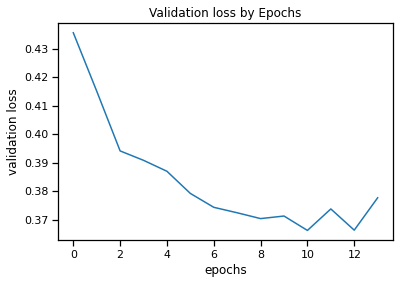

In [30]:
## Fit
epochs = 20 # number of epochs
dr = 0.002 # discount rate for learning rate scheduler 
lr_schedule = LearningRateScheduler(lambda epoch, lr0 = lr0, dr = dr: lr0*np.exp(-dr*epoch)) # build learning rate scheduler -- max learning rate goes down with epochs
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3) # early stopping 
callbacks = [early_stopping, lr_schedule]
verbose = 1 
lstm.fit(epochs, callbacks, verbose) # fit model!
fig, ax = plt.subplots()
sns.lineplot(range(len(lstm.history.history['val_loss'])), lstm.history.history['val_loss']); # track validation loss
ax.set(xlabel = 'epochs', ylabel = 'validation loss', title = 'Validation loss by Epochs');
# lstm.savemod('dynamic') # save model

# Predict
test_date = end_train + np.timedelta64(nahead, 'D') # date we want to predict for -- specifically, nahead days after the end of training 
lstm.predict(test_date, Generator) # predict for that date

# Get MSE
ytesthat = lstm.fitted.reshape(-1) 
ytest = lstm.ytest.reshape(-1)
mse_ = mse(ytest, ytesthat)
print('MSE:', mse_)



#### Dynamic updates

This section conducts the dynamic updates. After the model has been initially fit, we add data date-by-date. Specifically, we iteratively add one more day's data and update the model by running an additional fit with just one epoch. We then form predictions for that date. We want to form predictions for each date since we want to make sure we are predicting future values using only already-observed data. We use only one epoch per date because we find that the validation loss did not increase with more epochs on each date but rather with more dates.

In [119]:
last_date = mob.date.max() - np.timedelta64(nahead, 'D') # last date we want to train through (nahead days before the last in the dataset)
end_train = end_first_train 
print(f"first date: {str(end_train)[5:10]}\nlast date: {str(last_date)[5:10]}")
while end_train <  last_date: # while we we're still nahead days before the last date 
    
    print(str(end_train)[5:10])
    
    # Turn off standardization, get new date
    train_standardization = False # don't want to re-train standardization
    end_train = end_train + np.timedelta64(1, 'D') # move the end of training forward one 

    # Get data
    lstm.get_data(mob, train_standardization, end_train) # get data with new end_train 

    # Update
    epochs = 1 # just one epoch here -- adding more didn't seem to do much
    callbacks = [early_stopping, lr_schedule]
    verbose = 2
    lstm.update(epochs, callbacks, verbose)

    # Predict
    test_date = end_train + np.timedelta64(nahead, 'D') # move test_datea head one day
    lstm.predict(test_date, Generator) # predict for new test_date

first date: 03-22
last date: 04-23


TypeError: Cannot compare type 'Timestamp' with type 'int'

#### Save/load model and predictions

In [79]:
# # Save model and preds
# lstm.savemod('dynamic') # save the model
# preds = lstm.preds # get the predictions
# preds.to_csv('models/preds.csv', index = False) # save predictions


In [33]:
# Or just load everything if model is already fit

lstm.loadmod('dynamic') # load model
preds = pd.read_csv('models/preds.csv') # load 
preds['date'] = preds['date'].apply(lambda date: dt.strptime(date, '%Y-%m-%d')) # make into datetime
preds = preds.merge(pop, how = 'left', on = ['state','county']) # add in population
preds['fitted_og'] = np.exp(preds['fitted']) - 1 # get it on original scale
preds['observed_og'] = np.exp(preds['observed']) - 1 # get it on original scale


____
___

# 5. Assess Model Performance

This section is used to assess our model. Though the model is technically learning more with each date, it essentially converges after running 15 or 20 updates. This still leaves about 2 weeks of predictions to evaluate the model with. So, we look only at predictions made about three weeks after the initial fit. The first plot below shows overall observed values versus fitted values of `logcasespc`. Note that this represents about two weeks' worth of data, so each county is represented about 14 times. For instance, the outlier at the top represents exclusively observations from New York City. We also print out the MSE, which is quite low!

Finally, we visually inspect the model by showing observed values versus fitted values for each date in several counties. The blue line represents the observed number of cases in that county on each day and the orange line represents what we forecast it to be `nahead` days prior. We find that the predictions are spot on, on average but are too jagged. This is presumably due to the fact that we are constantly updating the model.

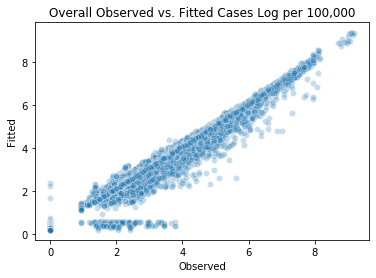

In [41]:
## Plot overall observed values vs. fitted values 
past_date = end_first_train + np.timedelta64(20,'D') # want it past a certain date -- model still adapting for the first few test dates
preds_past_date = preds[preds['date'] >= past_date]
fig = sns.scatterplot(preds_past_date['observed'], preds_past_date['fitted'], alpha = 0.25)
fig.set_xlabel('Observed')
fig.set_ylabel('Fitted')
fig.set_title('Overall Observed vs. Fitted Cases Log per 100,000');

In [39]:
## Print overall RMSE on original scale (past cutoff date -- see above)
mse_ = mse(preds_past_date['observed_og'], preds_past_date['fitted_og']) 
print('RMSE:', np.sqrt(mse_))

RMSE: 64.6415806751949


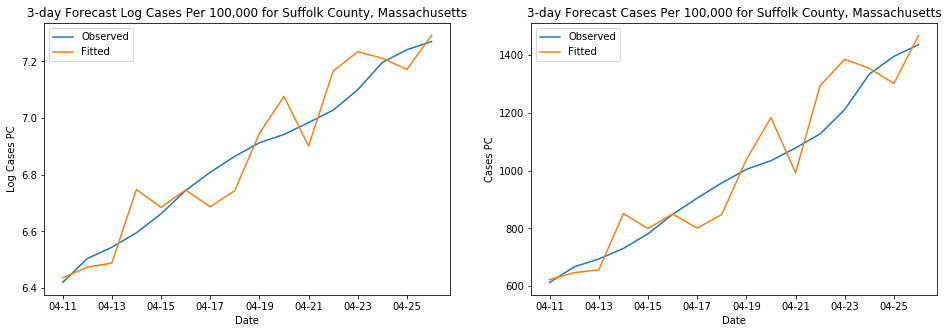

In [43]:
## Visualize a single county's trend line 

# pick county
county = 'Suffolk'
state = 'Massachusetts'
county_preds = preds[(preds['county'] == county) & (preds['state'] == state) & (preds['date'] >= past_date)].copy() # get just that county

# figure aesthetics
date = county_preds.date.astype(str).str.replace('2020-','') # make date prettier
xticks = xticklabels = date.iloc[::2] # change labels

# plot
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
# plot log (thing we actually fit)
sns.lineplot(date, county_preds['observed'], label = 'Observed', ax = ax[0])
sns.lineplot(date, county_preds['fitted'], label = 'Fitted', ax = ax[0])
ax[0].set(xlabel = 'Date', ylabel = 'Log Cases PC', title = f'{nahead}-day Forecast Log Cases Per 100,000 for {county} County, {state}',
      xticks = xticks, xticklabels = xticklabels)
# plot unlogged version 
sns.lineplot(date, np.exp(county_preds['observed']) - 1, label = 'Observed', ax = ax[1])
sns.lineplot(date, np.exp(county_preds['fitted']) - 1, label = 'Fitted', ax = ax[1])
ax[1].set(xlabel = 'Date', ylabel = 'Cases PC', title = f'{nahead}-day Forecast Cases Per 100,000 for {county} County, {state}',
      xticks = xticks, xticklabels = xticklabels);

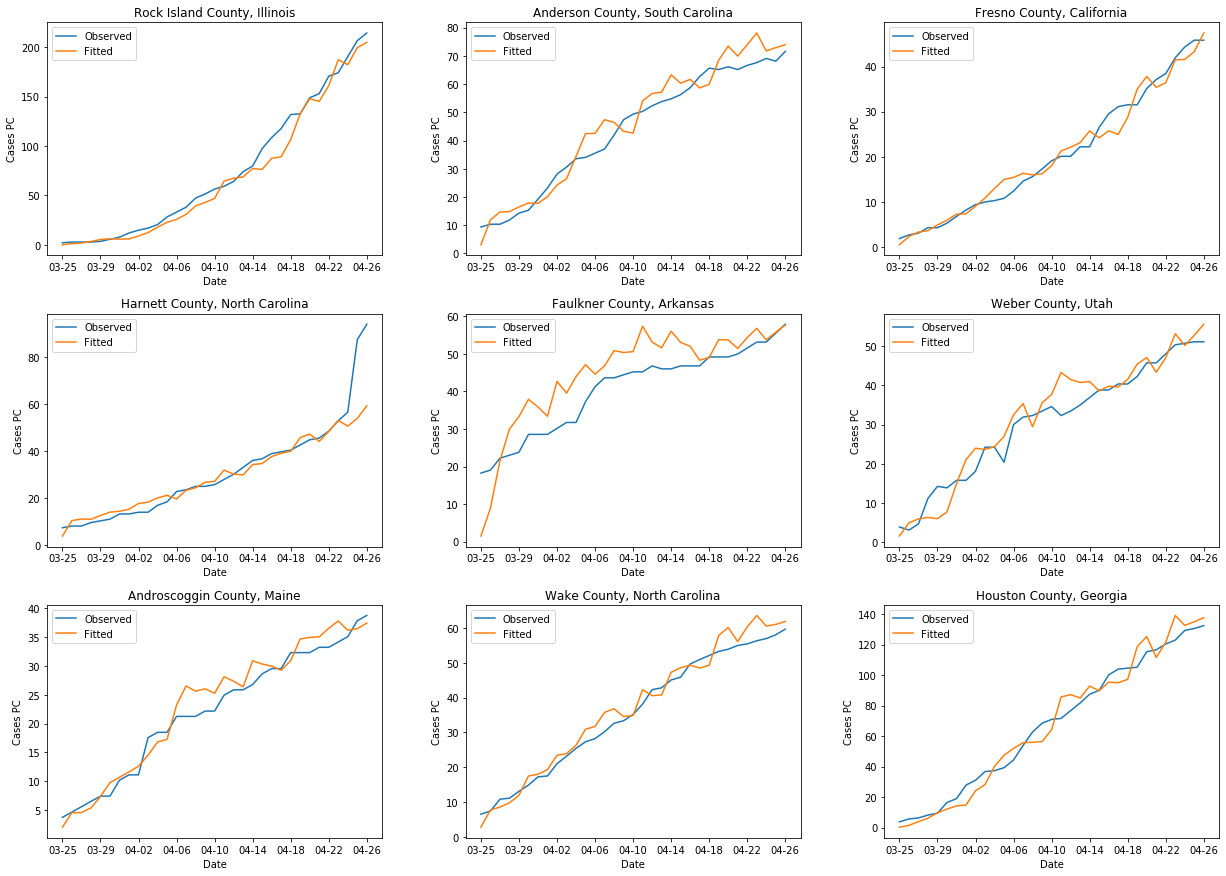

In [31]:
## Visualize for many counties

minsize = 100000 # only plotting counties of popualtion minsize or larger
county_state_combos = np.array(list(preds.groupby(['county','state']).
                                    filter(lambda x: x['pop'].iloc[0] > minsize).
                                    groupby(['county','state']).groups.keys())) # get county/state combos
nrow, ncol = 3, 3 # plot this many counties
indices = np.random.choice(np.arange(len(county_state_combos)), nrow*ncol, replace = False)
fig, axes = plt.subplots(nrow, ncol, figsize = (ncol*7, nrow*5))
for i, ax in enumerate(axes.ravel()):
    # same plotting as above 
    county, state = county_state_combos[indices[i]] 
    county_preds = preds[(preds['county'] == county) & (preds['state'] == state)].copy()
    date = county_preds.date.astype(str).str.replace('2020-','')
    xticks = xticklabels = date.iloc[::4]
    sns.lineplot(date, np.exp(county_preds['observed']) - 1, label = 'Observed', ax = ax)
    sns.lineplot(date, np.exp(county_preds['fitted']) - 1, label = 'Fitted', ax = ax)
    ax.set(xlabel = 'Date', ylabel = 'Cases PC', title = f'{county} County, {state}',
      xticks = xticks, xticklabels = xticklabels);
    
plt.subplots_adjust(hspace = 0.25, wspace = 0.25)


____
____

# 6. Conclusion

We find that our LSTM is able to accurately forecast future cases at the county level using just previous case counts and mobility data. We find that our 3-day forecasts for almost every large city are very close to the actual observed values. This is based on two metrics: First, the plot above shows that our forecast line is on par with the observed values for most major counties. Though there is a disappointing level of variation, the forecasts are spot-on on average and show limited deviation. Second, we monitor both the mean squared error of the log cases per 100,000 and the original cases per 100,000. This metric is somewhat difficult to interpret since infection rates per capita vary so wildly at the county level (e.g. missing by 100 in New York City is impressive while the same is not true for counties in rural Wyoming). We find an RMSE of roughly 64.6 on the original scale, suggesting on average we miss by around 65 cases per 100,000. This is, however, very heavily influenced by outliers, e.g. in New York where we are lucky to get within a couple hundred. As the charts above show, for most counties we are much closer than 65 on most dates.

Our modeling process showed us several beneficial practices for forecasting this disease. First, dynamic training is hugely important. When we first tried building a model on a certain time period and predicting for a later period using only this training, our model performed extremely poorly, reliably under-predicting for the largest counties. Second, we find that making predictions at the county level is much preferable to making predictions at the state level since a) mobility rates vary significantly between even neighboring counties and b) this provides much more data. Finally, we find that including information on mobility helps the model significantly. An equivalent model to the one built above without the mobility data consistently showed an MSE of about 0.075, which is around a 20% increase. 

Finally, we also identify two major flaws of our model. First, the model appears essentially unable to accurately predict when a county will have its first case. This is sensible given our model approach since it is difficult to distinguish one county that is soon to experience COVID cases from another that is safe for the time being. Second, the model makes very jaggedy predictions. Though the predictions are accurate on average, they deviate too much from the previous trend. Several approaches could be used to combat this effect: first, we could simply fit the model several times and take the average, hoping that the jaggedness is only due to noise and the noise will balance out. Second, we could take a Bayesian approach, averaging the model's predictions with the previous trend line. Finally, we could use some sort of ensemble model, combining the predictions of several different models to reduce variability in our predictions.

____
____